# Pr-Tmax cross-correlation

Assessment of model Pr-Tmax monthly anomalies cross-correlation 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
from xskillscore import pearson_r

import utils

In [17]:
# Metric calculation

def calc_pt_corr(da_p, da_t):
    """Calculate the cross correlation between Pr and Tasmax"""

    monthly_p = da_p.resample(time='M').sum(dim='time')
    monthly_clim_p = monthly_p.groupby("time.month").mean(dim="time")
    monthly_anom_p = monthly_p.groupby("time.month") - monthly_clim_p

    monthly_t = da_t.resample(time='M').mean(dim='time')
    monthly_clim_t = monthly_t.groupby("time.month").mean(dim="time")
    monthly_anom_t = monthly_t.groupby("time.month") - monthly_clim_t
    
    monthly_anom_t = monthly_anom_t.chunk(dict(time=-1))
    monthly_anom_p = monthly_anom_p.chunk(dict(time=-1))

    corr = pearson_r(monthly_anom_t, monthly_anom_p, 'time')

    return corr.compute()

In [18]:
# Data collection and processing

def get_assessment_time_bounds(gcm, task):
    """Get assessment time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date


def get_training_time_bounds(gcm):
    """Get xvalidation training time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '1980-01-01'
        end_date = '1999-12-31'
    else:
        start_date = '1960-01-01' 
        end_date = '1989-12-31'
    
    return start_date, end_date


def get_obs_data(start_date, end_date):
    """Get obs data"""
    
    da_pr_obs = utils.get_npcp_data(
        'pr',
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    da_tasmax_obs = utils.get_npcp_data(
        'tasmax',
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return calc_pt_corr(da_pr_obs, da_tasmax_obs)


def get_gcm_data(gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']

    da_pr_gcm = utils.get_npcp_data(
        'pr',
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    da_tasmax_gcm = utils.get_npcp_data(
        'tasmax',
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )

    return calc_pt_corr(da_pr_gcm, da_tasmax_gcm)
    

def get_rcm_data(gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    
    da_pr_rcm = utils.get_npcp_data(
        'pr',
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    da_tasmax_rcm = utils.get_npcp_data(
        'tasmax',
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return calc_pt_corr(da_pr_rcm, da_tasmax_rcm)


def get_bias_corrected_rcm_data(gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
    
    da_pr_ecdfm = utils.get_npcp_data(
        'pr',
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_tasmax_ecdfm = utils.get_npcp_data(
        'tasmax',
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['ecdfm'] = calc_pt_corr(da_pr_ecdfm, da_tasmax_ecdfm)
    
    da_pr_qme = utils.get_npcp_data(
        'pr',
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_tasmax_qme = utils.get_npcp_data(
        'tasmax',
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['qme'] = calc_pt_corr(da_pr_qme, da_tasmax_qme)
    
    if task == 'xvalidation':
        da_pr_qdm = utils.get_npcp_data(
            'pr',
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_tasmax_qdm = utils.get_npcp_data(
            'tasmax',
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_dict['qdm'] = calc_pt_corr(da_pr_qdm, da_tasmax_qdm)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict


def get_bias_corrected_gcm_data(gcm, task, start_date, end_date):
    """Get bias corrected GCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
    
    da_pr_ecdfm = utils.get_npcp_data(
        'pr',
        gcm,
        'GCM',
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_tasmax_ecdfm = utils.get_npcp_data(
        'tasmax',
        gcm,
        'GCM',
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['ecdfm'] = calc_pt_corr(da_pr_ecdfm, da_tasmax_ecdfm)
        
    if task == 'xvalidation':
        da_pr_qdm = utils.get_npcp_data(
            'pr',
            gcm,
            'GCM',
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_tasmax_qdm = utils.get_npcp_data(
            'tasmax',
            gcm,
            'GCM',
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_dict['qdm'] = calc_pt_corr(da_pr_qdm, da_tasmax_qdm)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [19]:
# Plotting

def plot_bias(ax, corr_obs, corr_model, model_name, ob_fractions=None):
    """Plot the bias for a particular model"""
    
    bias = corr_model - corr_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    mae = np.nanmean(np.abs(bias)) 

    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=[-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        extend='both',
        cbar_kwargs={'label': 'correlation'},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f}', transform=ax.transAxes, fontsize='large')
    ax.set_title(model_name)
    ax.coastlines()


def plot_comparison(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    gcm,
    rcm,
    task,
    outfile=None,
):
    """Plot the complete comparison"""

    ncols = 5 if task == 'xvalidation' else 3
    plot_nums = np.arange(1, (ncols * 2) + 1)
    ob_fractions = utils.get_pr_weights(gcm, task)
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm1, da_obs, da_gcm, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm2, da_obs, gcm_bc_dict['ecdfm'], f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_gcm4, da_obs, gcm_bc_dict['qdm'], f'{gcm} (qdm)', ob_fractions=ob_fractions,
        )
        plot_index = plot_index + 1

    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm1, da_obs, da_rcm, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm2, da_obs, rcm_bc_dict['ecdfm'], f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm3, da_obs, rcm_bc_dict['qme'], f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm4, da_obs, rcm_bc_dict['qdm'], f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm5, da_obs, da_training_obs, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Bias (model minus obs) in the {start_year}-2019 monthly PT cross correlation', fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def plot_corr(ax, corr, model_name, ob_fractions=None):
    """Plot the PT correlation for a particular model"""
    
    corr = utils.clip_data(corr, utils.get_aus_shape())
    if ob_fractions is not None:
        corr = utils.mask_by_pr_ob_fraction(corr, ob_fractions, threshold=0.9)    

    corr.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=[-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
        extend='both',
        cbar_kwargs={'label': 'correlation'},
    )
    ax.set_title(model_name)
    ax.coastlines()


def plot_values(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    gcm,
    rcm,
    task,
    outfile=None,
):
    """Plot the correlation for each model/method"""

    ncols = 5 if task == 'xvalidation' else 4
    plot_nums = np.arange(1, (ncols * 2) + 1)
    ob_fractions = utils.get_pr_weights(gcm, task)
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_gcm1, da_gcm, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_gcm2, gcm_bc_dict['ecdfm'], f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_corr(
            ax_gcm4, gcm_bc_dict['qdm'], f'{gcm} (qdm)', ob_fractions=ob_fractions,
        )

    plot_index = plot_index + 1
    ax_obs = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(ax_obs, da_obs, 'AGCD', ob_fractions=ob_fractions)
        
    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_rcm1, da_rcm, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_rcm2, rcm_bc_dict['ecdfm'], f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_rcm3, rcm_bc_dict['qme'], f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_corr(
            ax_rcm4, rcm_bc_dict['qdm'], f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_corr(
            ax_rcm5, da_training_obs, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'{start_year}-2019 monthly PT cross correlation', fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()


In [21]:
def plot_rcm(
    da_obs,
    da_gcm,
    gcm_bc_dict,
    gcm,
    rcm,
    task,
    start_date,
    end_date,
    da_training_obs=None,
    value_plot=False,
    bias_outfile=False,
    value_outfile=False,
):
    """Generate plots for one RCM/GCM combination"""
    
    da_rcm = get_rcm_data(gcm, rcm, start_date, end_date)
    rcm_bc_dict = get_bias_corrected_rcm_data(gcm, rcm, task, start_date, end_date)
    if bias_outfile:
        bias_outfile_name = f'ptcorr-bias_task-{task}_{gcm}_{rcm}.png'
    else:
        bias_outfile_name = None
    if value_outfile:
        value_outfile_name = f'ptcorr-values_task-{task}_{gcm}_{rcm}.png'
    else:
        value_outfile_name = None
    
    if value_plot:
        plot_values(
            da_obs,
            da_gcm,
            da_rcm,
            gcm_bc_dict,
            rcm_bc_dict,
            da_training_obs,
            gcm,
            rcm,
            task,
            outfile=value_outfile_name,
        )
    plot_comparison(
        da_obs,
        da_gcm,
        da_rcm,
        gcm_bc_dict,
        rcm_bc_dict,
        da_training_obs,
        gcm,
        rcm,
        task,
        outfile=bias_outfile_name,
    )

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

#### ERA5

In [22]:
#gcm = 'ECMWF-ERA5'
#task = 'historical'
#start_date, end_date = get_assessment_time_bounds(gcm, task)
#da_obs = get_obs_data(start_date, end_date)
#da_gcm = get_gcm_data(gcm, start_date, end_date)
#gcm_bc_dict = get_bias_corrected_gcm_data(gcm, task, start_date, end_date)

In [23]:
#rcm = 'BOM-BARPA-R'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

In [24]:
#rcm = 'CSIRO-CCAM-2203'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

In [25]:
#rcm = 'UQ-DES-CCAM-2105'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

#### ACCESS-ESM1-5

In [26]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(start_date, end_date)
da_gcm = get_gcm_data(gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(gcm, task, start_date, end_date)

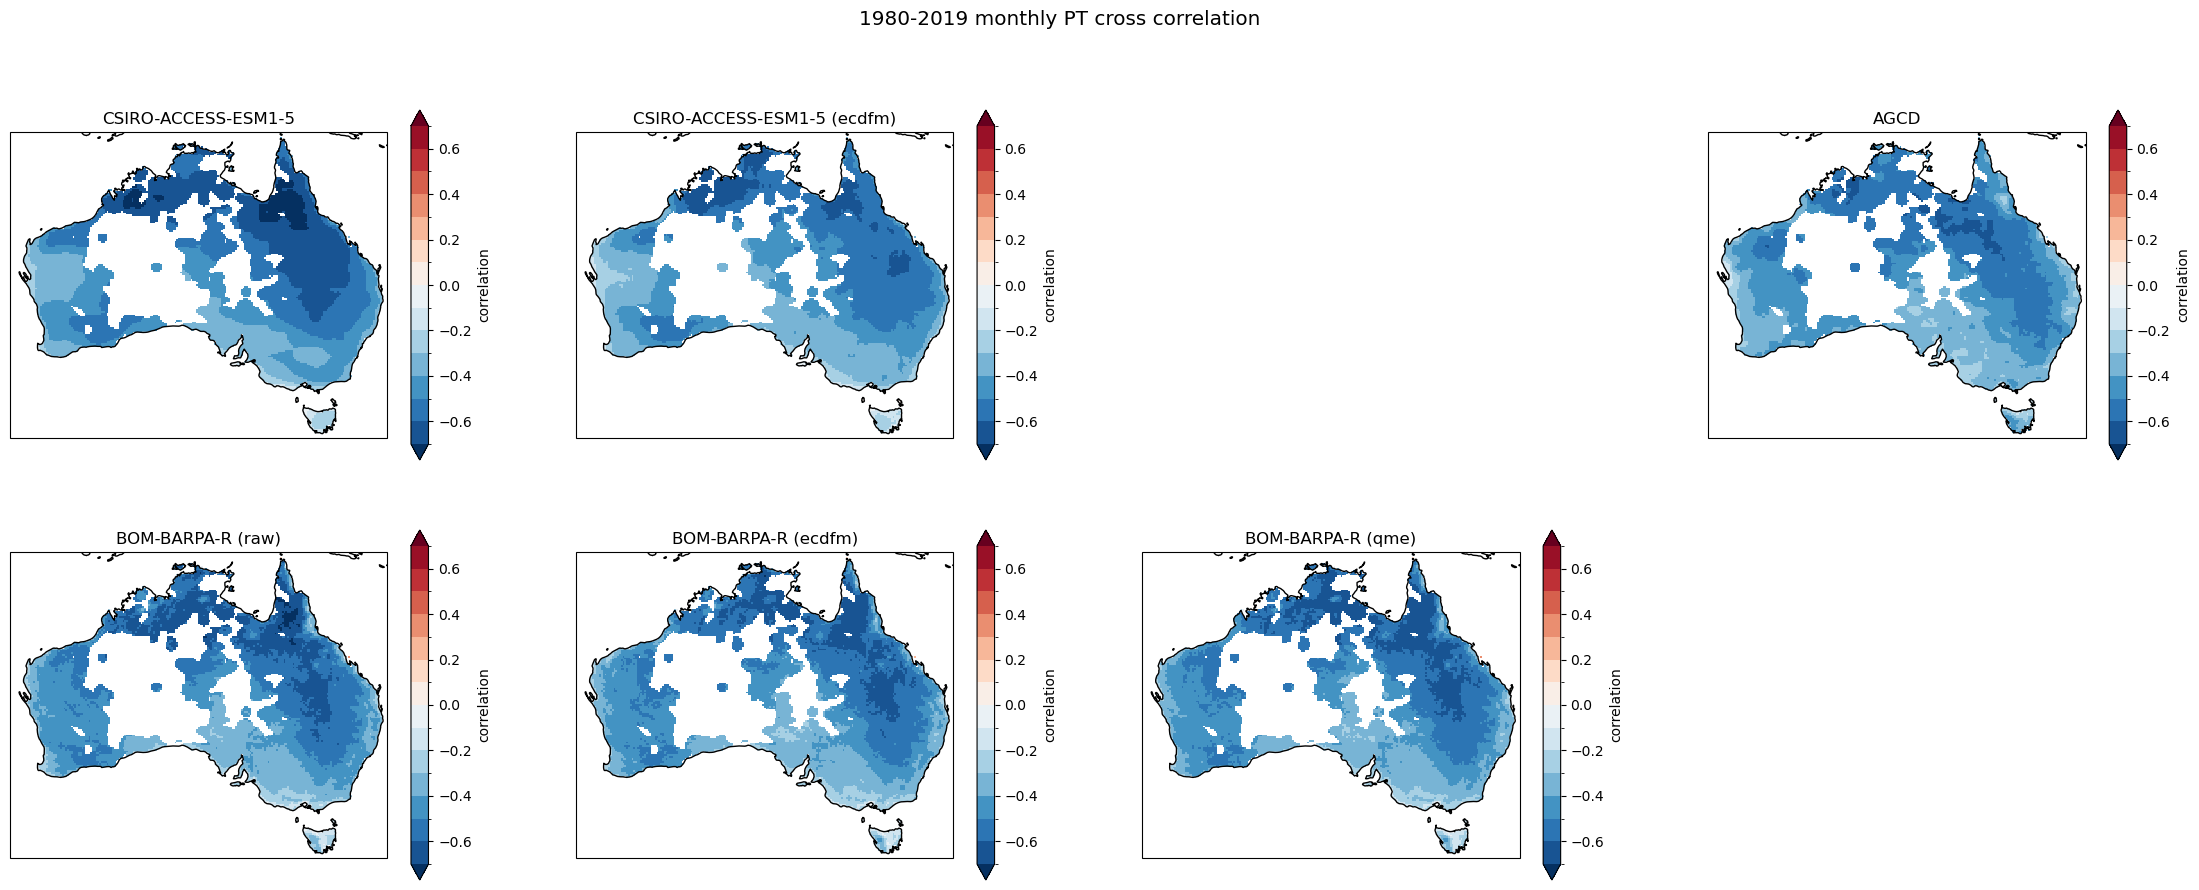

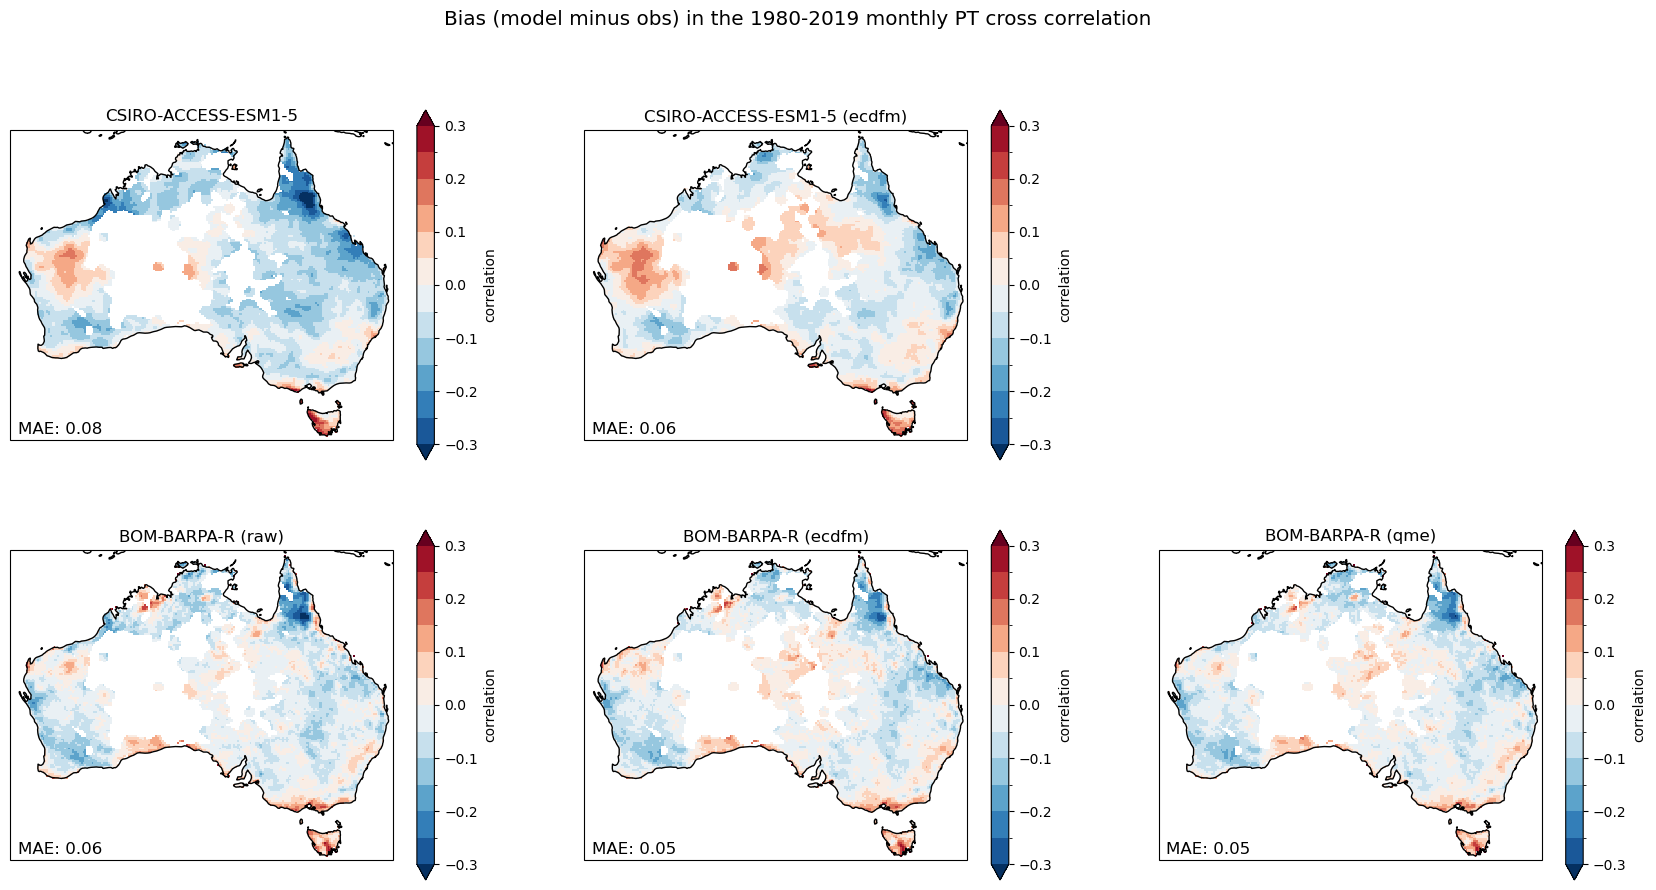

In [27]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, value_plot=True)

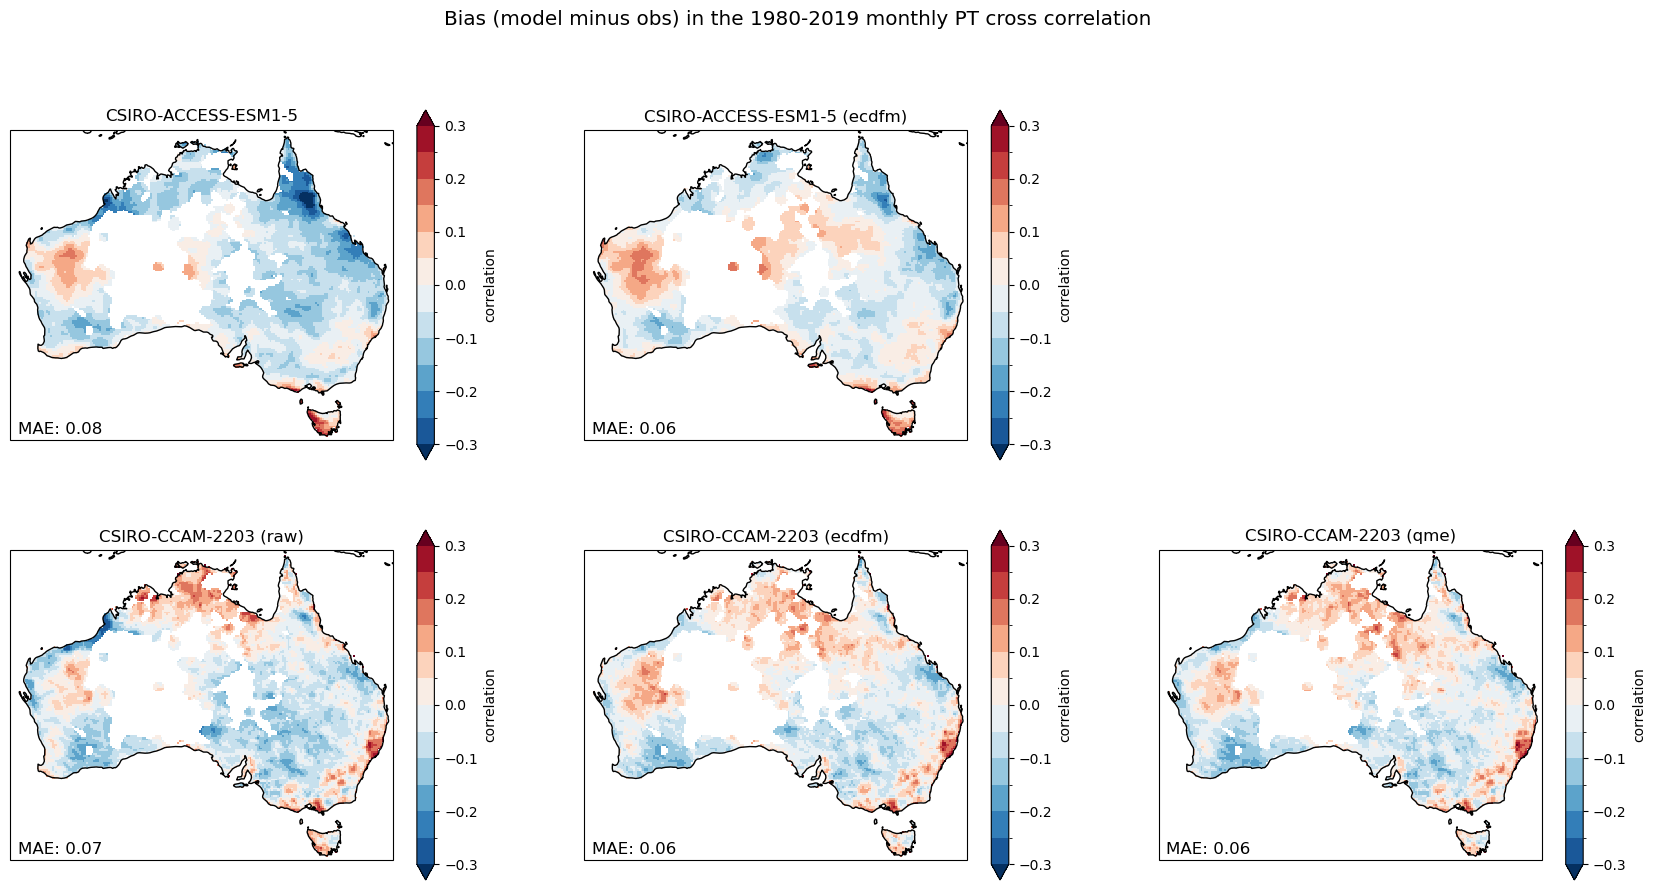

In [28]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

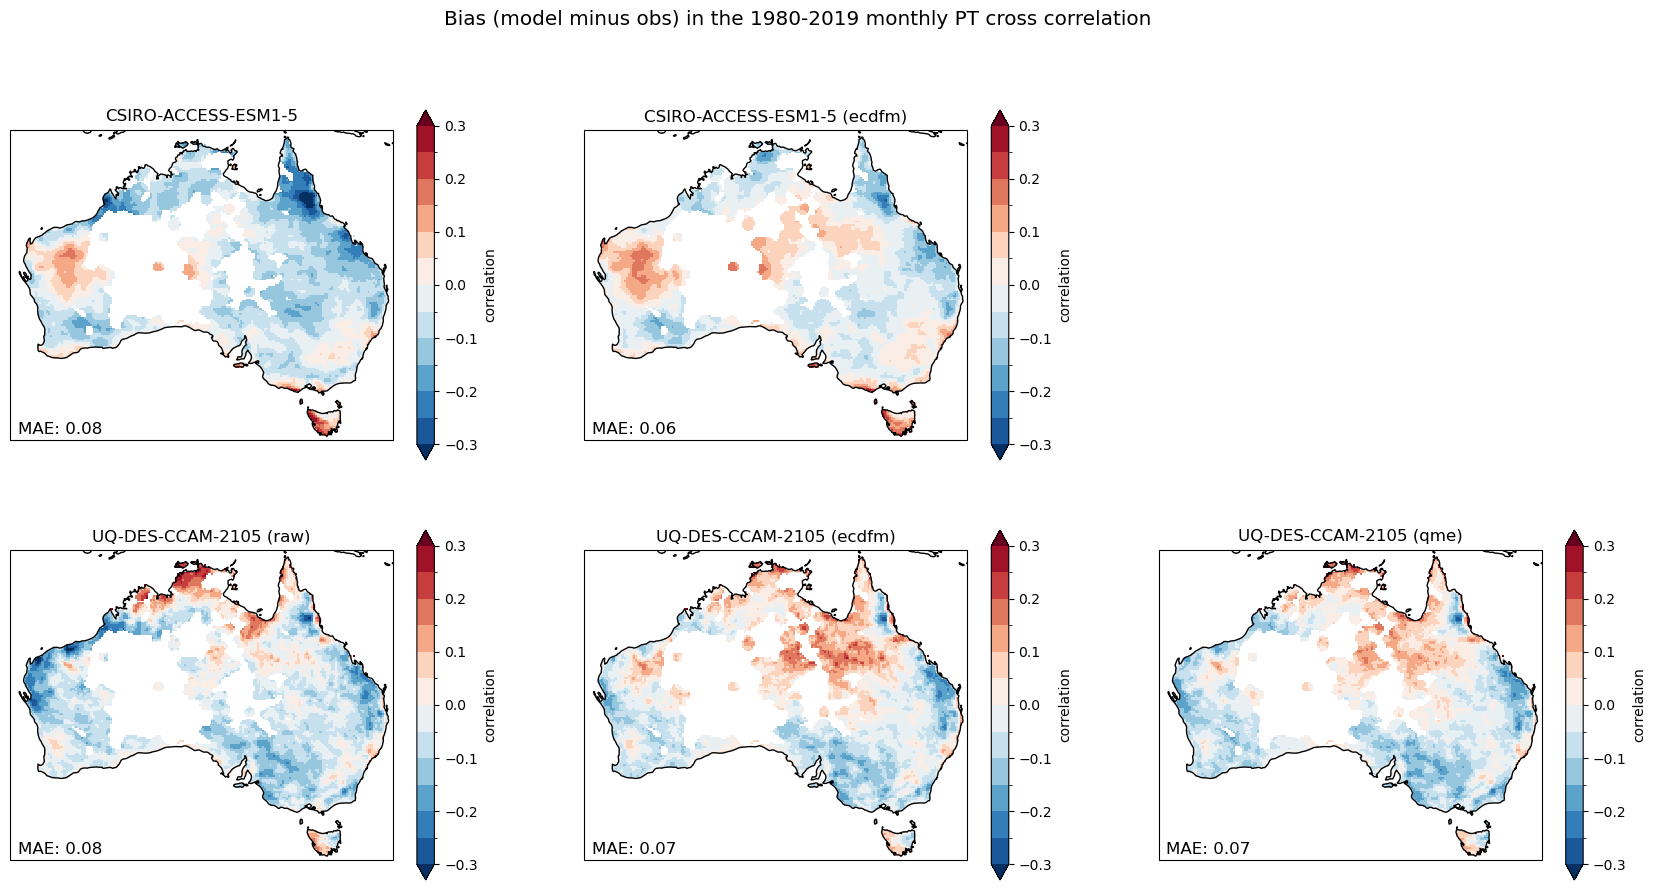

In [29]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [14]:
#gcm = 'ECMWF-ERA5'
#task = 'xvalidation'
#start_date, end_date = get_assessment_time_bounds(gcm, task)
#da_obs = get_obs_data(start_date, end_date)
#da_gcm = get_gcm_data(gcm, start_date, end_date)
#gcm_bc_dict = get_bias_corrected_gcm_data(gcm, task, start_date, end_date)

#training_start, training_end = get_training_time_bounds(gcm)
#da_training_obs = get_obs_data(training_start, training_end)

In [15]:
#rcm = 'BOM-BARPA-R'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict gcm, rcm, task, start_date, end_date, da_training_obs)

In [16]:
#rcm = 'CSIRO-CCAM-2203'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)

In [17]:
#rcm = 'UQ-DES-CCAM-2105'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [30]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(start_date, end_date)
da_gcm = get_gcm_data(gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(training_start, training_end)

ptcorr-values_task-xvalidation_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


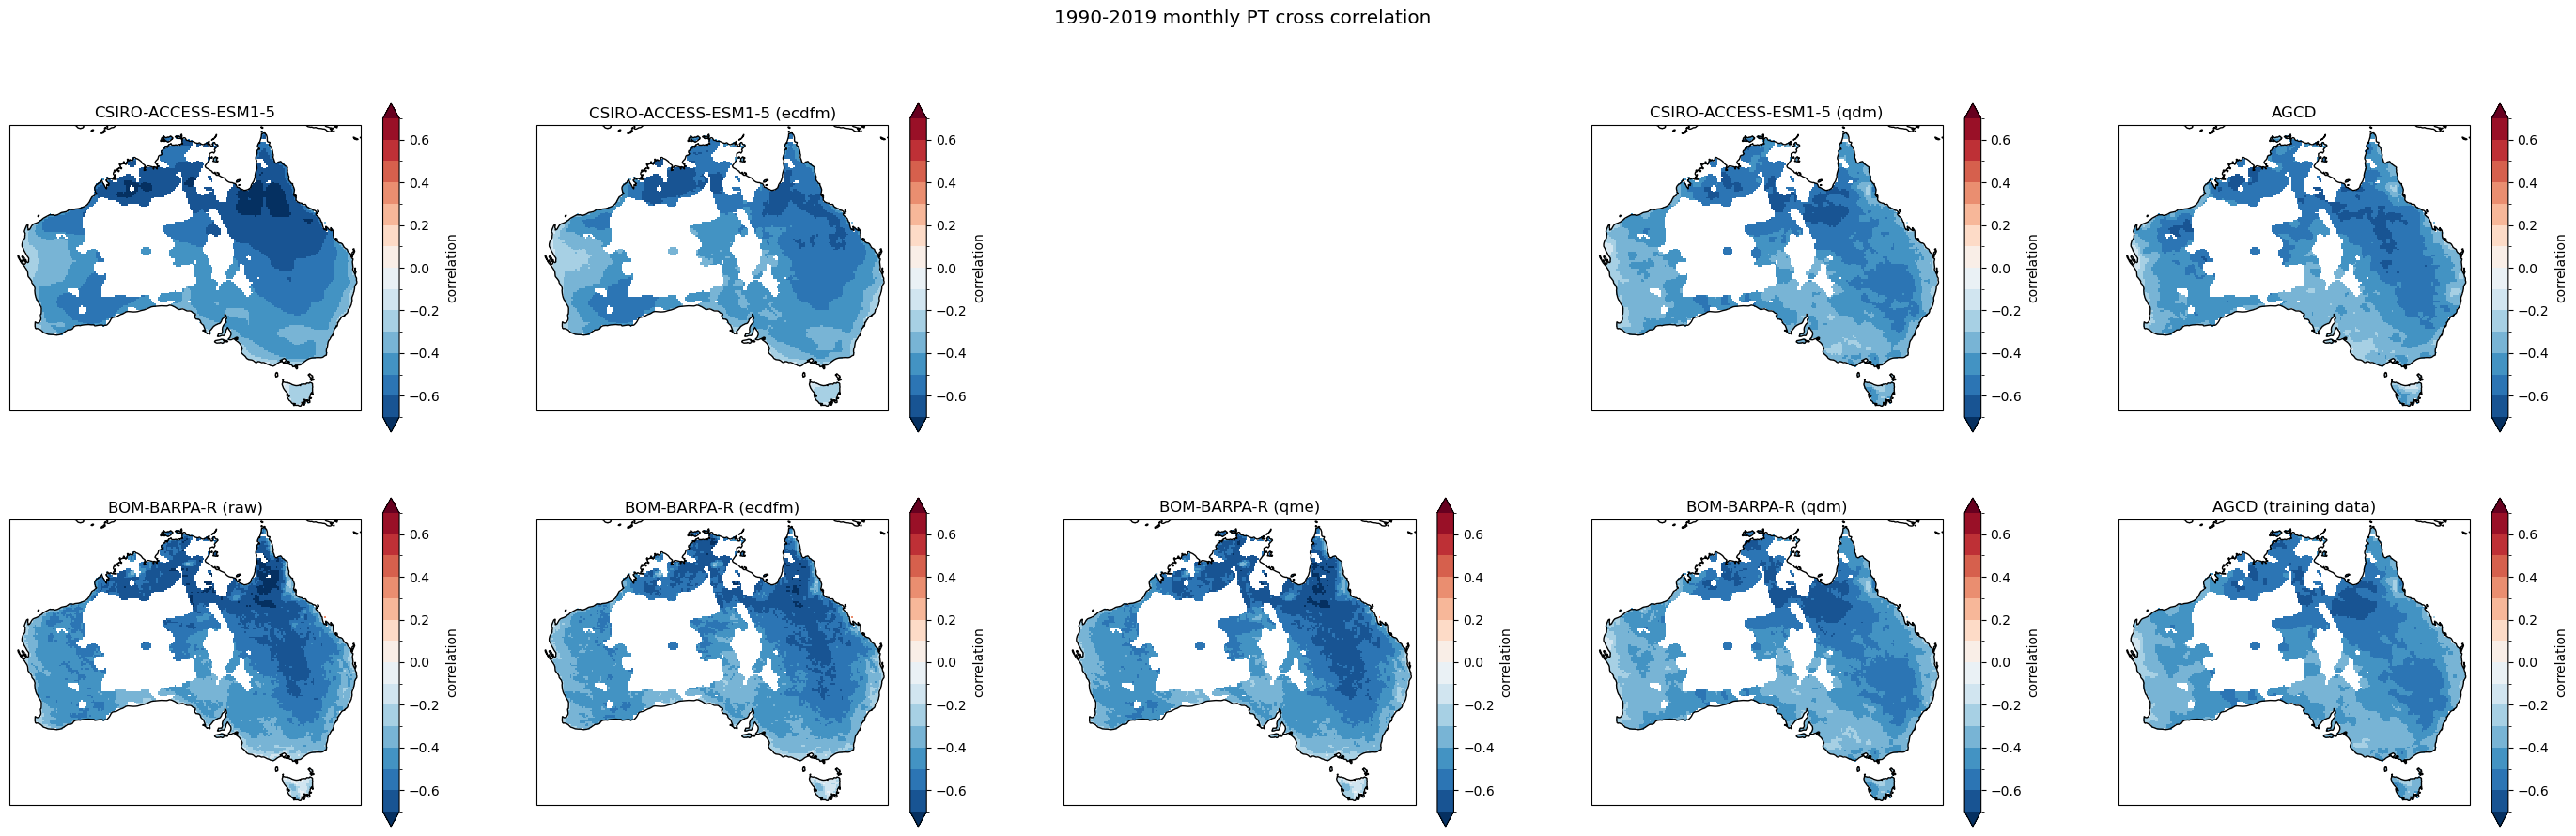

ptcorr-bias_task-xvalidation_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


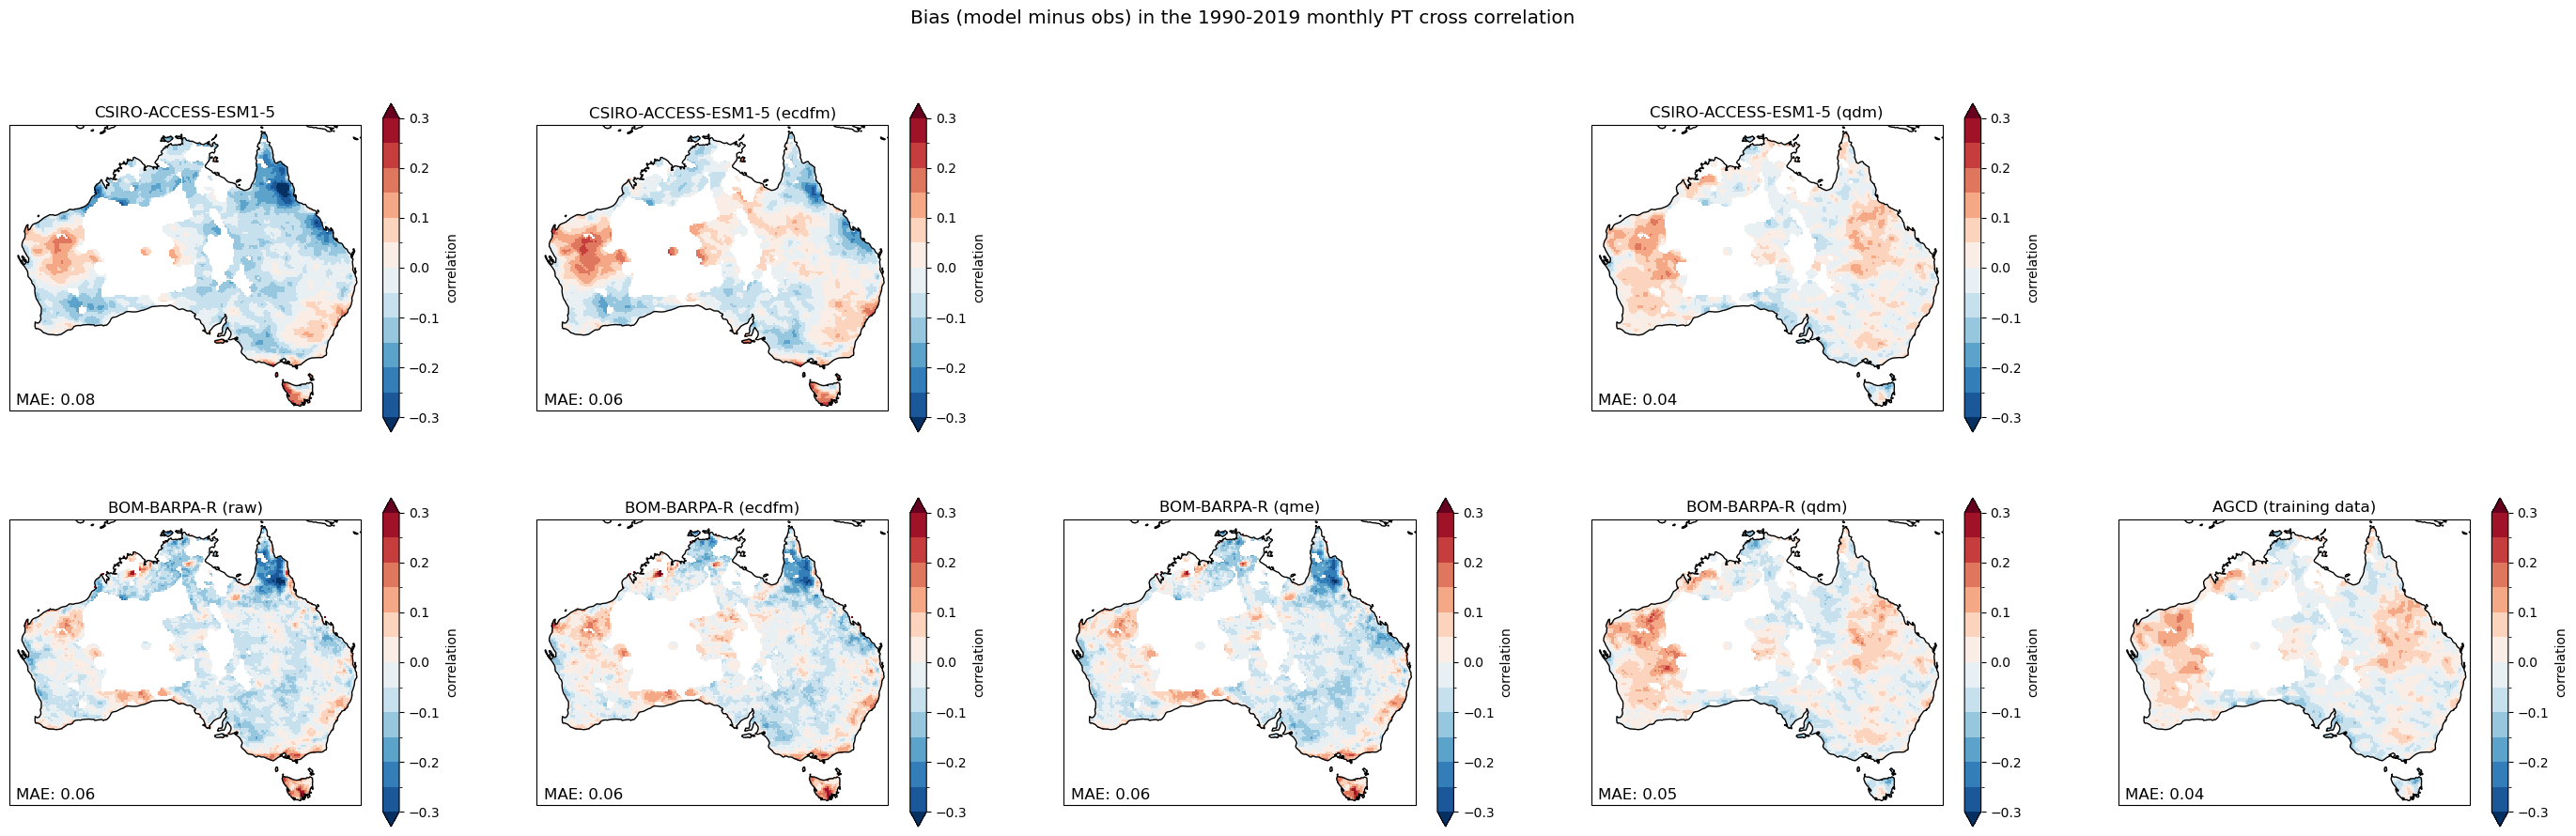

In [31]:
rcm = 'BOM-BARPA-R'
plot_rcm(
    da_obs,
    da_gcm,
    gcm_bc_dict,
    gcm,
    rcm,
    task,
    start_date,
    end_date,
    da_training_obs,
    bias_outfile=True,
    value_outfile=True,
    value_plot=True
)

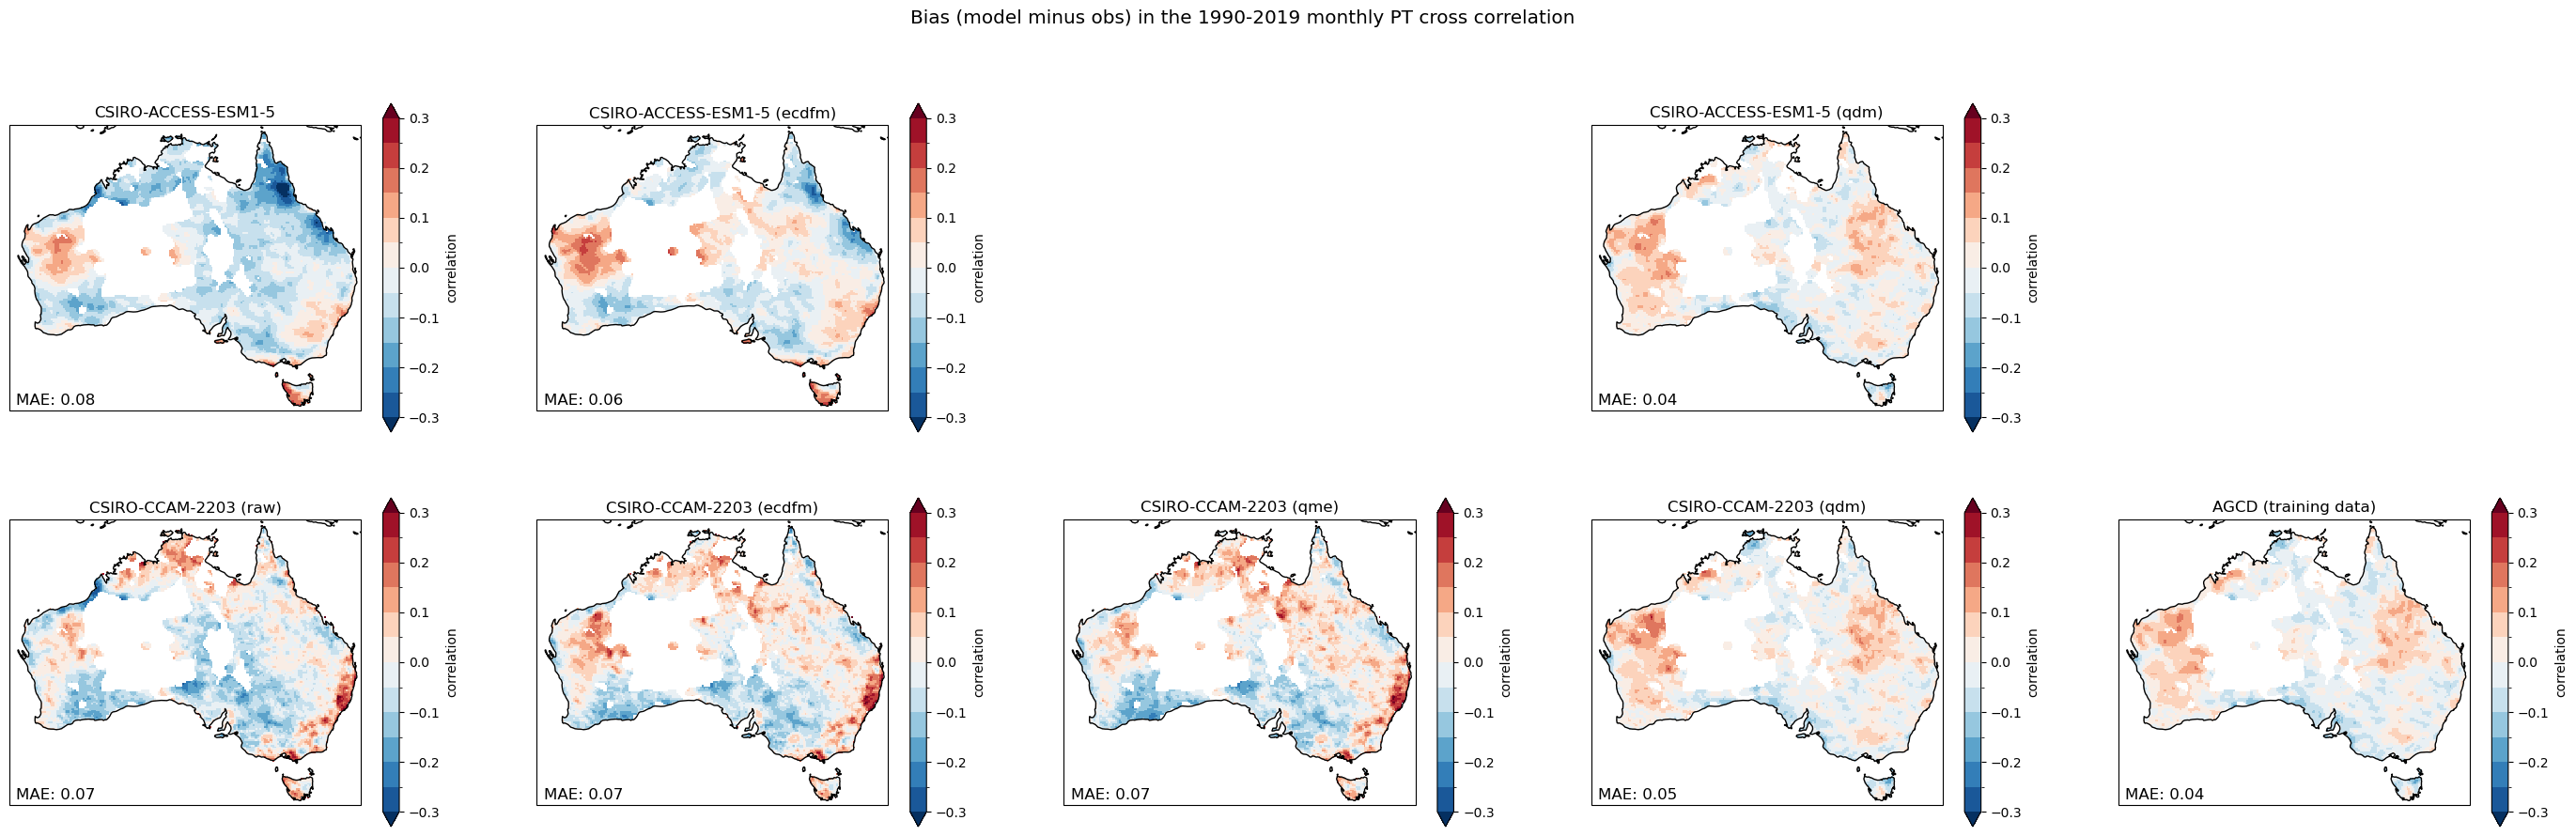

In [32]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)

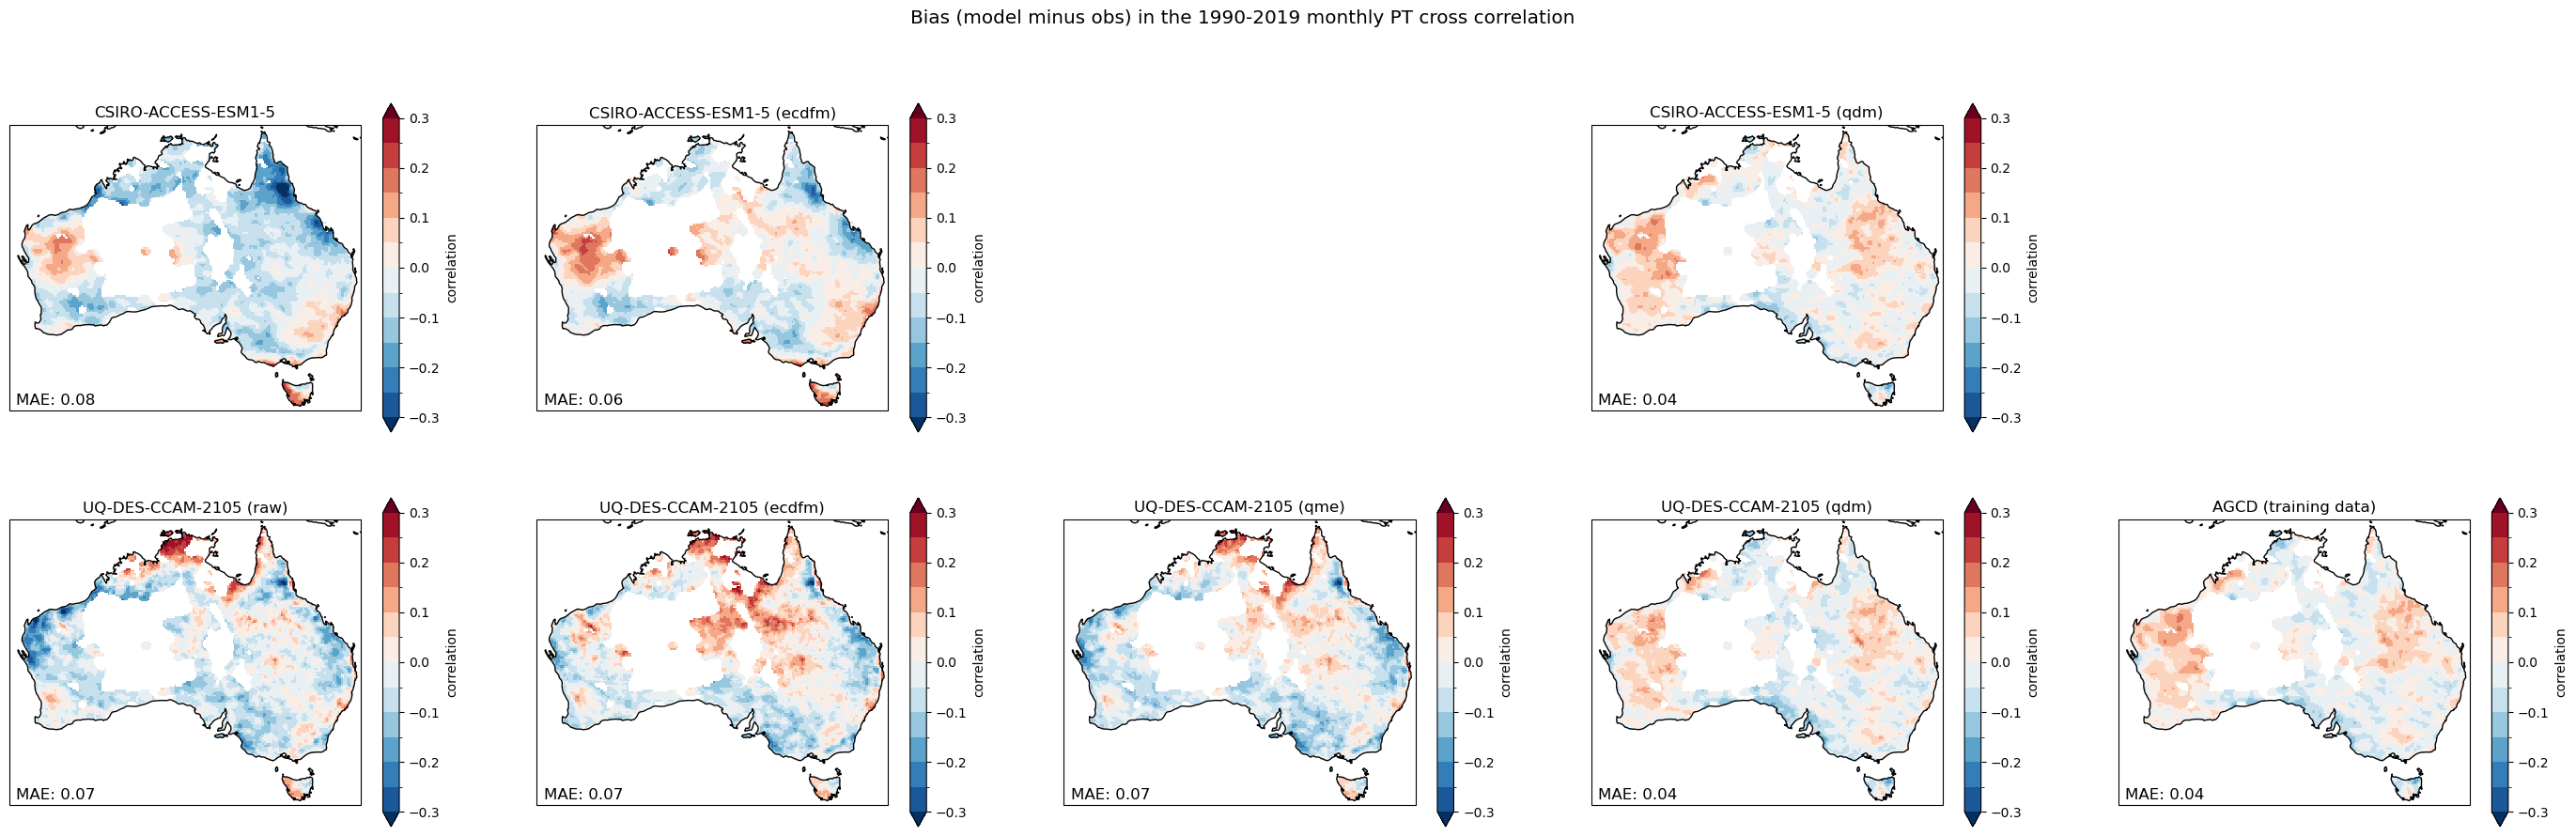

In [34]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)